# Review Notes: Time Series Analysis

**Basic Procedure for Time Series Analysis/Modeling:**
1. Detrend the series with differencing (aka make it stationary)
2. Look at ACF and PACF to determine probable order of model (p, d, q)
3. Confirm model parameters by analyzing AIC/BIC
4. Fit the model to the correct parameters
5. Validate accuracy
6. Forecast into the future

## Preprocessing
1. Make sure the column containing the date information is in datetime or timestamp format
    * Format datetime objects: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
2. Make the now datetime/timestamp column the index
3. Check for missing values
    * Deal with missing values in one of 3 ways:
        * Drop the rows containing null values
        * Fill the missing values under defined augmentation/criterion
            * .bfill( ) - impute the missing value with the value of the next valid instance in the data (backward filling)
            * .ffill( ) - impute the missing value with the value of the previous valid instance (carry forward)
        * Use machine learning algorithms (e.g. regression) to predict the missing value

In [ ]:
# Convert the date column to datetime (the format argument is optional)
df.column_name = pd.to_datetime(df.column_name, format='%d/%m/%y')

# Set the datetime/timestamp column the idex
df.set_index('column_name', inplace = True)

# Check for missing values
df.isnull()
### Or
df.isnull().sum()

# Deal with missing values
## Backward filling
df.data_column.fillna(df.data_column.bfill())

## Forward Filling
df.data_column.fillna(df.data_column.ffill())

## Resampling and Grouping
### Downsampling
Sample the data from the datetime index based on chronological measures (i.e. months, years)

```python
# Downsample daily data to monthly mean
df_monthly= df.resample('MS')
month_mean = df_monthly.mean() # Will return a df with the mean value of each month's data
```

### Upsampling
Increase the frequency of the timestamps in the datetime index based on chronological measures (i.e. half-days). This will create NaN values, which will need to be dealt with (ffill( ) or bfill( ) or prediction)

```python
# Upsample without managing NaN values
df_bidaily= df.resample('12H').asfreq()

# Upsample while dealing with NaN values
df_bidaily_fill= df.resample('12H').ffill()
```

### Slicing Data by Date
Used when you want to retrieve data from/between specific dates

```python
# Return data collected from 1985 to the end of the dataset
df_1985_onwards = df['1985':]

# Return data collected between 1990 and 1991
monthly_mean['1990-01-01':'1991-01-01']
```

### Grouping with pd.Grouper( )
Regroup the time series for a given interval (i.e. weekly, monthly, yearly).

Pandas Grouper Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html

Aliases for Grouper: http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

```python
# Use pandas grouper to group values using annual frequency
year_groups = df.groupby(pd.Grouper(freq ='A')) # 'A' refers to annual

# Reorganize the grouped df for visualizations
## Create a new DataFrame and store yearly values in columns 
df_annual = pd.DataFrame()

for yr, group in year_groups:
    df_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots (individual)
df_annual.plot(figsize = (13,8), subplots=True, legend=True)
plt.show()

# Or plot overlapping lines on single plot 
df_annual.plot(figsize = (15,5), subplots=False, legend=True)
plt.show()

# Or, if the data is sparse, as dot plots (using the original df)
df.plot(figsize = (20,6), style = ".b")
plt.show()
```


## Visualization Methods (in addition to the line plots above)
### 1. Histogram and Density Plots
Important to view the distribution of the observations without the temporal ordering to determine normality for statistical testing.

```python
# Histogram
df.hist(figsize = (10,6), bins = 7)
plt.show()

# KDE
df.plot(kind='kde', figsize = (15,10))
plt.show()
```

### 2. Box Plots
Can be used to view the distribution of the observations based on a specified time interval (i.e. monthly, yearly)

```python
# Generate a box and whiskers plot (side-by-side by year) for the data that was transformed with pd.Grouper()
df_annual.boxplot(figsize = (12,7))
plt.show()
```

### 3. Heat Maps
Can be used to compare observations between intervals
* Rotate (transpose) the ```df_annual``` dataframe as a new matrix so that each row represents one year and each column one day. This provides a more intuitive, left-to-right layout of the data.
* Use ```matshow()``` function to draw a heatmap for transposed yearly matrix.
    * Documentation: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.matshow.html
    
```python
# Create a heatmap of the df
year_matrix = df_annual.T
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()
```

## Identifying Trends
### Stationarity
A time series said to be stationary if there is no trend or seasonality (i.e. its mean, variance, and covariance remain constant over time).
* Models function under the assumption that the time series is stationary (if the series shows a particular behavior over time, it is likely that behavior will continue into the future)
* **Dickey Fuller Test for Stationarity** - statistical method to determine stationarity of a time series
    * Null Hypothesis - time series is **NOT** stationary
        * Thus, if the test results in a p-value less than 0.01, the time series **IS** stationary
    * This test uses the stricter p-value of 0.01
        
```python
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(time_series_object)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                         'Number of Observations Used'])

# Format the output
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
# Print formatted output    
print ('Results of Dickey-Fuller Test:')

print(dfoutput)
```
### Types of Trends
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index. Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture. 

The trends listed below can be seen in isolation or in combination across time series data.

#### 1. Linear Trends
* The observations increase (or decrease) over time

#### 2. Exponential Trends
* The observations increase at an exponential rate over time

#### 3. Periodic Trends (Seasonal Effects)
* The observations increase and decrease following a pattern over time

#### 4. Changes in Variance
* The variation in the observations increases (or decreases) over time

### Testing/Analyzing Trends
If the Dickey Fuller test mentioned above fails to reach significance, the result indicates that the time series displays some sort of trend. The following methods can be used to analyze such trends.

#### Rolling Statistics
Changes in the mean or variance over time can be calculated for analysis

```python
# Calculate the rolling mean (window = number of time steps to use in rolling mean)
rolmean = time_series_object.rolling(window = 8, center = False).mean()

# Calculate the rolling variance (window = number of time steps to use in rolling variance)
rolstd = time_series_object.rolling(window = 8, center = False).std()
```



## Removing Trends
While most time series models have a stationarity assumption, almost no time series data is stationary. Thus, techniques will need to be employed to remove the trends and seasonality as best as possible.

### 1. Log Transformation
* Makes the values more uniform over time
* Use np.log( ) on the time series object
* If log transformation does not work, you can try square root or cub root transformations

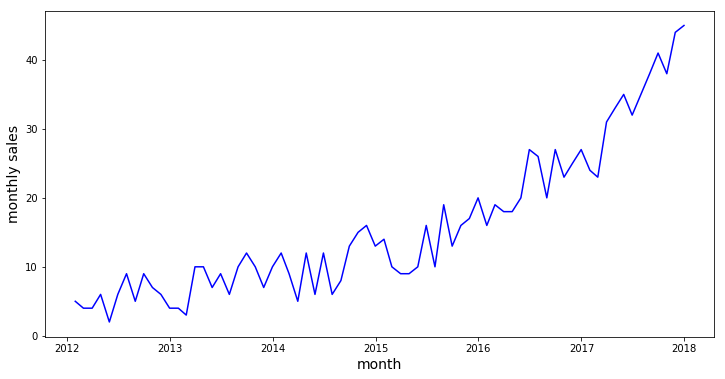

In [13]:
# Import necessary packages
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Generated monthly sales - ORIGINAL DATA
years = pd.date_range('2012-01', periods=72, freq="M")
index = pd.DatetimeIndex(years)

np.random.seed(3456)
sales= np.random.randint(-4, high=4, size=72)
bigger = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,
                   3,3,3,3,3,3,3,3,7,7,7,7,7,7,7,7,7,7,7,
                   11,11,11,11,11,11,11,11,11,11,18,18,18,
                   18,18,18,18,18,18,26,26,26,26,26,36,36,36,36,36])
final_series = sales+bigger+6
data = pd.Series(final_series, index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("monthly sales", fontsize=14)
plt.show()

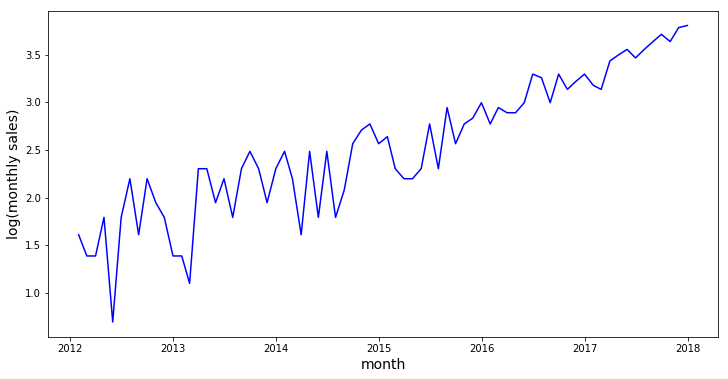

In [2]:
# Perform log transformation
data = pd.Series(np.log(final_series), index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("log(monthly sales)", fontsize=14)
plt.show()

**Analysis:** Log transforming the data made it more linear, but seems to have increased the heteroskedascity (variance is more varied).

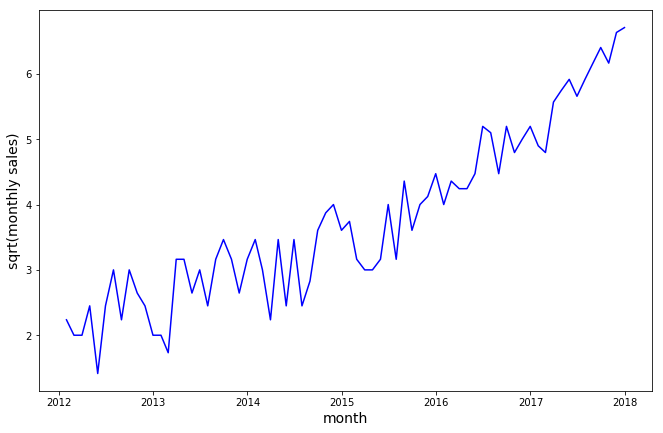

In [3]:
# Take the square root of the raw data
data = pd.Series(np.sqrt(final_series), index=index)
fig = plt.figure(figsize=(11,7))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("sqrt(monthly sales)", fontsize=14)
plt.show()

**Analysis:** Taking the square root of the raw data slightly reduced the exponential trend and did not contribute to the heteroskedascity.

### 2. Subtract the Rolling Mean
* Subtract the rolling mean from the raw data to make it more stationary

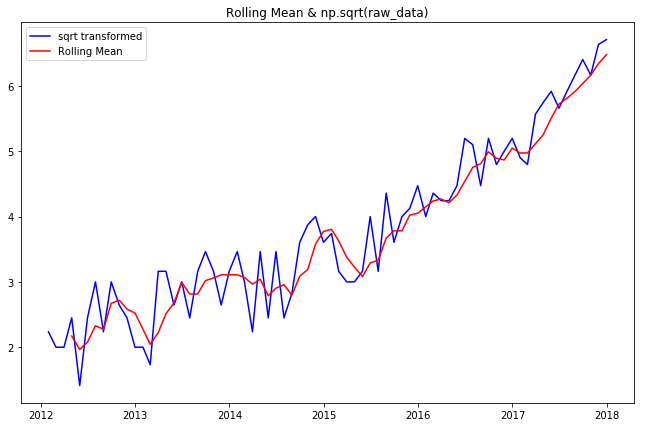

In [7]:
# Calculate the rolling mean of the square root transformed data and plot both
rolmean = data.rolling(window = 4).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(data, color='blue',label='sqrt transformed')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & np.sqrt(raw_data)')
plt.show(block=False)

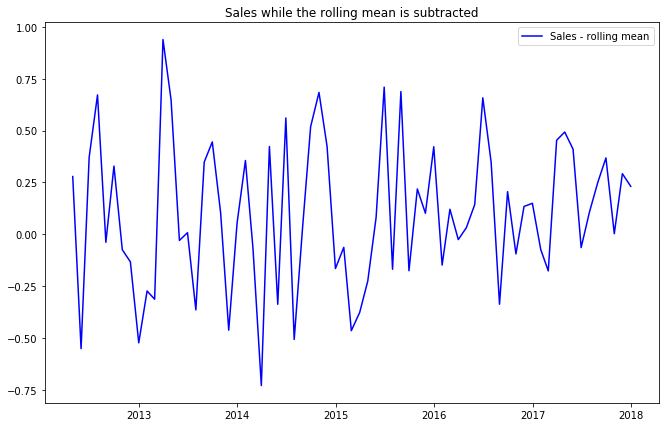

In [5]:
# Subtract the moving average from the np.sqrt tranformed data and check head for Nans
data_minus_rolmean = data - rolmean

# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

# Plot data after the subtracting the rolling mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

**Analysis:** Subtracting the rolling mean has made the time series stationary. Note, changing the window for the rolling mean will affect the resultant series after subtraction.

### 2b. Subtract the Weighted Rolling Mean
* The weighted rolling mean (wma, weighted moving average) is a rolling mean where more recent observations are given a higher weight.
    * Exponential weighted moving average - one method for assigning weights where all previous values are assigned weights based on an exponential decay factor
        * Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

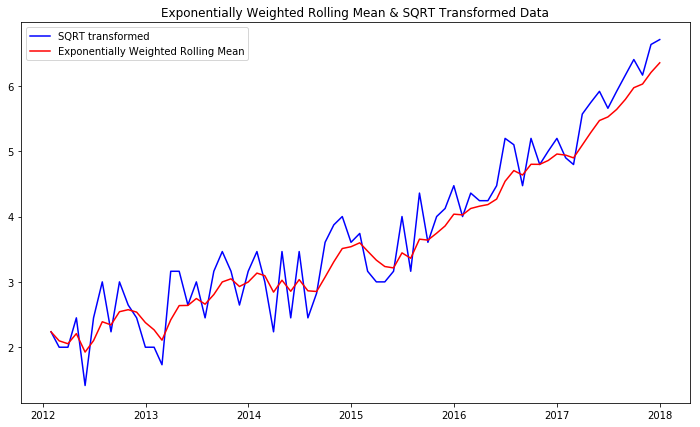

In [9]:
# Use Pandas ewma() to calculate Weighted Moving Average of np.sqrt transformed data
exp_rolmean = data.ewm(halflife = 2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(data, color='blue',label='SQRT transformed')
mean = plt.plot(exp_rolmean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & SQRT Transformed Data')
plt.show(block=False)

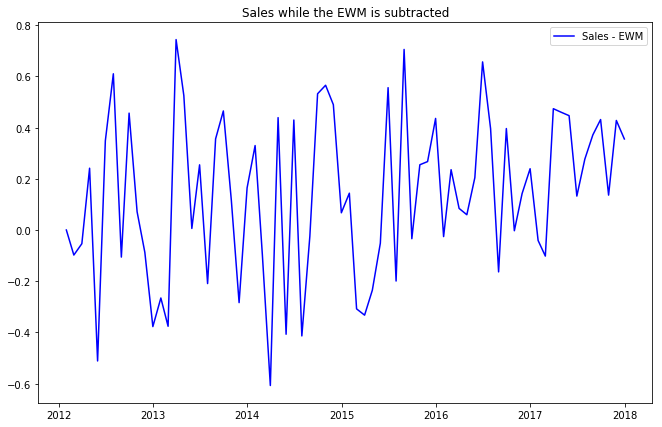

In [11]:
# Subtract the moving average from the np.sqrt transformed data and check head for Nans
data_minus_exp_rolmean = data - exp_rolmean
data_minus_exp_rolmean.head(15)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='blue',label='Sales - EWM')
plt.legend(loc='best')
plt.title('Sales while the EWM is subtracted')
plt.show(block=False)

**Analysis:** Again, subtracting the exponentially weighted mean appears to have made the np.sqrt transformed data stationary. But, it is no more stationary than when the rolling mean was subtracted.

### 3. Differencing
* Common method for dealing with both trends and seasonality at the same time.
* Subtract the value of one time instance from another time instance
    * The period of time between the two instances is called the "lag"
    * Set the period equal to the duration of the seasonality to remove
* Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html

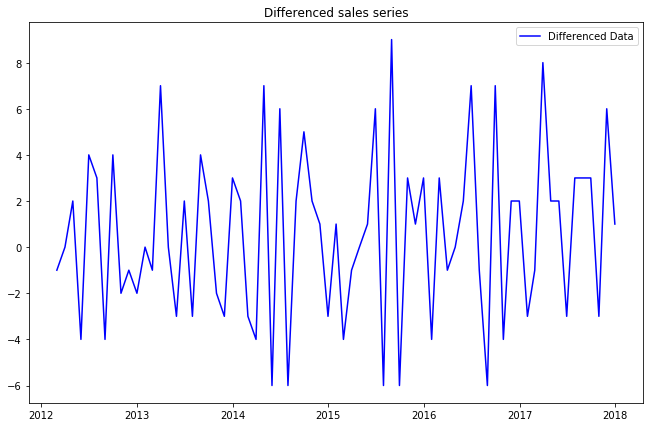

In [14]:
# data is the np.sqrt transformed data
data_diff = data.diff(periods=1)

fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Differenced Data')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [15]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['#Passengers']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

## Decomposing a Time Series

Mathematical procedure to transform the time series into several components:
1. Seasonal - patterns that repeat within the time series in a fixed period of time
2. Trend - the underlying trend of the metrics
3. Residual - the remainder of the time series after the removal of seasonality and trends
    * **Further modeling would be performed on the residual**

Decomposition can be addititve or multiplicative based on the nature of the time series
1. Additive - An additive model is linear where changes over time are consistently made by the same amount.
    * magnitude of the seasonality does not change over time
2. Multiplicative - A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
    * the magnitude of the seasonality increases/decreases over time

```python
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal_decompose module on log transformed time series (doesn't have to be log transformed)
decomposition = seasonal_decompose(np.log(ts))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
```

Another, more robust, method for decomposition is STL. It allows for more variations in trend and seasonality
* Documentation: https://pypi.org/project/stldecompose/

## Modeling

### Correlation and Autocorrelation
1. **Correlation:** Statistical measure to determine whether and by how much pairs of variables relate to each other
    * Time series need to be stationary to evaluate correlation in the following manner
    * Distribution of time series should be normal
```python
# Produce a table containing the correlation coefficients for the series in the dataframe
data_df.corr()
```
2. **Autocorrelation:** Method to evaluate how a time series instance is related to the historical instances in the series
    * Series with higher levels of autocorrelation are more predictable than series without autocorrelation
    * Lag 1 Autocorrelation equates to comparing each instance to the previous time step instance
        * Lag period can be modified
    * Distribution of time series should be normal
        
```python
# Shift the index of a specific series in the df forward by 1 step (can also shift backward with negative periods)
series_shift_1 = series.shift(periods=1)

# Combine the shifted series with its original values
lag_1= pd.concat([series_shift_1, series_original], axis=1)

# Produce the table of correlation coefficients. Results are read "lag-1 autocorrelation of x"
lag_1.corr()
```
* **Autocorrelation Function** - a function that represents autocorrelation of a time series as a function of the time lag.
     * get a summary of the autocorrelations for each lag
     * This can be performed on raw and de-trended data
     * The correlation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.
     * lag on the x-axis and the correlation value for each respective lag value on the y-axis.
     * dotted lines in the plot tell you about the statistical significance of the correlation
         * Spikes that extend beyong the dotted lines are significant
    * White Noise Series will show no significance 
    * Random Walk Series will show strong significance at first and then trail off
     
```python
# Create a figure
plt.figure(figsize=(12,5))

# Plot the autocorrelation function
pd.plotting.autocorrelation_plot(series);

# Another method to plot the autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series)
plt.show()
```

* **Partial Autocorrelation Function** - a summary of the relationship between a time series element with observations at a lag, with the *relationships of intervening observations removed*.
    * The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
    * gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags
    * can be interpreted as a regression of the series against its past lags
    * helps you come up with a possible order for the auto regressive term
    * White Noise Series will show no significance
    * Random Walk Series will show strong significance at lag-1 (and maybe lag-2), but no significance for lags beyond those
    
```python
# import libraries
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

# set figure parameters
rcParams['figure.figsize'] = 14, 5

# Plot the partial autocorrelation function for the first 100 lags
plot_pacf(series, lags = 100);
```

### Autoregressive Model
* The output value depends linearly on its own previous values and an error term
    * Mathematically, $$Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$
* The AR model may not be stationary
* The order of an AR model is denoted p
    * Would expect the ACF plot for the AR(p) time series to be strong to a lag of p and remian stagnant for subsequent lag values, trailing off at some point as the effect is weakened. the PACF, on the other hand describes the direct relationship between an observation and its lag. This generally leads to no correlation for lag values beyond p.

### Moving Average Model
* The output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.
* Can be described as the weighted sum of today's and yesterday's noise.
* Mathematically, $$Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$
* Common approach for modeling univariate time series
* The MA model will always be stationary
* The order of an MA model is denoted q.
    * Would expect the ACF for the MA(q) process to show a strong correlation with recent values up to the lag of q, then a immediately decline to minimal or no correlation. For the PACF, we would expect the plot to show a strong relationship to the lag and a tailing off to no correlation from the lag onwards.
    
### ARMA Model
* Combination of the autoregressive and moving average models
* A regression on past values takes place (AR part) and also that the error term is modeled as a linear combination of error terms of the recent past (MA part)
* Typically denoted ARMA(p,q)
* Time series needs to be detrended before modeling
    * These models assume seasonality can not happen
* Statsmodels implementation,

```python
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an ARMA(p,q) model to the first simulated data
mod_arma = ARMA(series, order=(p,q))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)
```
* **Evaluating the fit** - use either AIC or BIC. Both methods add a penalty term for the number of parameters in each model to combat selecting a model that is overfit/too complex (the penalty term is larger in BIC than in AIC). **The lower the AIC/BIC value, the better the fit of the model**
    * **Akaike Information Criterion (AIC)** - an estimator of the relative quality of statistical models for a given set of data
        * A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in **finding the model that yields the lowest AIC value**
    * **Bayesian information criterion (BIC)** - a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.
        * Based, in part, on the likelihood function
        * Not great for high-dimensional data

### Integrated ARMA (ARIMA) Models
* A model that can be fit to time series data in order to better understand or predict future points in the series.
* Depends on three variables that account for seasonality, trend, and noise:
    * Denoted as ARIMA(p, d, q)
    * **p** - autoregressive part of the model; incorporates the effect of past values into our model
        * Number of time lags
    * **q** - moving average part of the model; used to set the error of the model as a linear combination of the error values observed at previous time points in the past.
        * Difference between the moving average at ith instant and actual value.
    * **d** - Integrated component of an ARIMA model; This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation
* The **s** variable is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.) and also factors in as a "parameter" of seasonal ARIMA models
    * It will be a constant in the model to help remove seasonality

```python
### Boilerplate code of "grid search" for best parameters

# Define the p, d and q parameters to take any value between 0 and 2 (could be a larger range)
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], s_term) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_series,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Convert answers to df
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# Find the parameters with minimal AIC value.
ans_df.loc[ans_df['aic'].idxmin()]
```

* **Evaluate the fit** - again use AIC/BIC to select between different iterations of the model. Additionally, the "coef" column in the output from the code below shows the importance of each feature and how each one impacts the time series patterns. The P>|z| provides the significance of each feature weight. If the p-value is less than 0.05, then that feature significantly affects the model and should be retained

```python
## Produce a table of model parameters to analyze in depth
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(time_series,
                                order=(p, d, q),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

## Use model diagnostics to ensure no assumptions have be violated

# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()
```

### Model Diagnostics
* The purpose here is to ensure that residuals remain un-correlated, normally distributed having zero mean
    * In the top right plot output, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
    * The qq-plot on the bottom left of the plot output shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
    * The residuals over time (top left of the plot output) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right of the output, which shows that the time series residuals have low correlation with lagged versions of itself.
    
### Validate the Model
* Compare predicted values from the model to real values in the time series to assess accuracy of its forcasting
* Use the ```get_predictions()``` and ```conf_int()``` on the model variable ```output``` to generate predictions and the confidence interval of their accuracy, respectively.
    * For the ```get_predictions()``` method, set the dynamic parameter to ```False``` to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

```python
#### Get predictions starting from a specific date and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()

#### Plot real vs predicted values along with confidence interval

#Plot observed values
ax = time_series['1990':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

#### Also, check the mean squared error to assess accuracy of forecast (want this value to be as close to zero as possible)

# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = time_series['1998-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
```

### Dynamic Forecasting
* Use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.
* Note that ```dynamic=True``` for these generated predictions

```python
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = time_series['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

### Again, check the mean squared error to assess accuracy of forecast (want this value to be as close to zero as possible)

# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = time_series['1998-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
```

### Forecasting Future Values
* Use the ```get_forecast()``` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

```python
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals

ax = time_series.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()
```